In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
col_names = ['pregnant', 'glucose', 'bp', 'skin', 
             'insulin', 'bmi', 'pedigree', 'age', 'label']

In [3]:
diabetes = pd.read_csv('diabetes.csv', header=None, names=col_names)

In [4]:
diabetes

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [84]:
y = diabetes.label
X = diabetes.drop(['label'], axis=1)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
from sklearn.linear_model import LogisticRegression
cls = LogisticRegression()

In [8]:
cls.fit(X_train, y_train)

/home/nikita4735/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [9]:
y_pred = cls.predict(X_test)

In [10]:
from sklearn import metrics
metrics.confusion_matrix(y_test, y_pred)

array([[81, 20],
       [25, 28]])

Text(0.5, 15.0, 'Предсказанные значения')

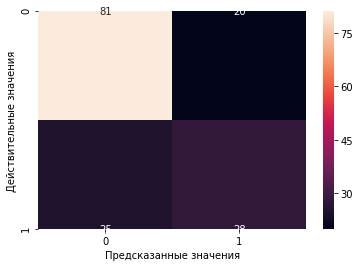

In [11]:
import  numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
 
class_names = [0, 1]
fig, ax = plt.subplots()
ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names)
plt.yticks(ticks, class_names)
 
sns.heatmap(pd.DataFrame(
    metrics.confusion_matrix(y_test, y_pred)),
    annot=True)
plt.ylabel('Действительные значения')
plt.xlabel('Предсказанные значения')

In [12]:
metrics.accuracy_score(y_test, y_pred)

0.7077922077922078

In [13]:
metrics.precision_score(y_test, y_pred)

0.5833333333333334

In [14]:
metrics.recall_score(y_test, y_pred)

0.5283018867924528

In [15]:
metrics.f1_score(y_test, y_pred)

0.5544554455445545

Так как метрика f1 всего 0.6, модель не очень хорошо классифицирует данные, в общем и целом модель неплохо работает с 1 классом

In [16]:
from sklearn.svm import SVC
cls = SVC(kernel='linear')

In [17]:
cls.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [18]:
y_pred = cls.predict(X_test)

In [19]:
metrics.f1_score(y_test, y_pred)

0.5454545454545454

Метрика f1 возрасла, но всё ещё небольшая

In [20]:
import torch
from torch import nn

Нормализуем фичи

In [155]:
X = ((X - X.mean(0))/X.std(0))

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [157]:
# Превратим данные в тензоры
X_train = torch.FloatTensor(X_train.to_numpy())
y_train = torch.LongTensor(y_train.to_numpy().reshape(-1,1))
X_test = torch.FloatTensor(X_test.to_numpy())
y_test = torch.LongTensor(y_test.to_numpy().reshape(-1,1))

Объявим модель

In [215]:
torch.manual_seed(42) 
np.random.seed(42)
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 50),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.BatchNorm1d(50),
    
    nn.Linear(50, 100),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.BatchNorm1d(100),
    
    nn.Linear(100, 200),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.BatchNorm1d(200),
    
    nn.Linear(200, 2)
)
    
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Обучающий цикл

In [216]:
def train(X_train, y_train, X_test, y_test, num_epoch):
    train_losses = []
    test_losses = []
    y_train = y_train.squeeze_()
    y_test = y_test.squeeze_()
    for i in range(num_epoch):
        model.train(True)
        # Посчитаем предсказание и лосс
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        # зануляем градиент
        optimizer.zero_grad()

        # backward
        loss.backward()

        # ОБНОВЛЯЕМ веса
        optimizer.step()
        train_losses.append(loss.item())
        
        # Теперь посчитаем лосс на тесте
        model.train(False)
        with torch.no_grad():
            p_test = model(X_test)
            y_test
            test_losses.append(loss_fn(p_test, y_test).item())
        print('Epoch: ', i+1, 'Loss: ', loss.item())       
    return train_losses, test_losses

In [217]:
train_losses, test_losses = train(X_train, y_train, X_test, y_test, 100)

Epoch:  1 Loss:  0.778380811214447
Epoch:  2 Loss:  0.7427787184715271
Epoch:  3 Loss:  0.7300137877464294
Epoch:  4 Loss:  0.7105304598808289
Epoch:  5 Loss:  0.6728140711784363
Epoch:  6 Loss:  0.6470770239830017
Epoch:  7 Loss:  0.6412818431854248
Epoch:  8 Loss:  0.6865615844726562
Epoch:  9 Loss:  0.6665231585502625
Epoch:  10 Loss:  0.6353225111961365
Epoch:  11 Loss:  0.626880407333374
Epoch:  12 Loss:  0.6168286204338074
Epoch:  13 Loss:  0.6309725046157837
Epoch:  14 Loss:  0.6261119842529297
Epoch:  15 Loss:  0.5999100208282471
Epoch:  16 Loss:  0.6091107726097107
Epoch:  17 Loss:  0.5982733368873596
Epoch:  18 Loss:  0.5910252332687378
Epoch:  19 Loss:  0.6009562015533447
Epoch:  20 Loss:  0.5896185040473938
Epoch:  21 Loss:  0.5801253914833069
Epoch:  22 Loss:  0.5886536240577698
Epoch:  23 Loss:  0.5852970480918884
Epoch:  24 Loss:  0.5756074786186218
Epoch:  25 Loss:  0.574420154094696
Epoch:  26 Loss:  0.5619084239006042
Epoch:  27 Loss:  0.5928686857223511
Epoch:  28 Lo

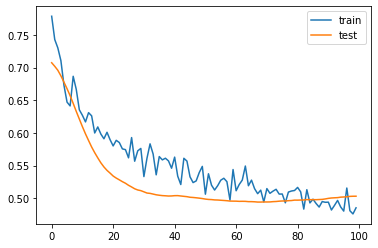

In [218]:
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()
plt.show()

In [219]:
model.eval()
train_pred_labels = model.forward(X_train).max(dim=1).indices
test_pred_labels = model.forward(X_test).max(dim=1).indices

In [220]:
metrics.f1_score(y_test, test_pred_labels)

0.6666666666666665

Использование полносвязной многослойной нейронной сети повысило f1 до 0.66. Одной из проблем неудовлетворительного качества может являться небольшое количество данных.